In [1702]:
import pandas as pd
import matplotlib.pyplot as plt

In [1703]:
# Importing the dataset
bigdf = pd.read_csv("megaGymDataset.csv")
bigdf = bigdf.rename(columns={'Unnamed: 0': 'index'})

<h1>Data Analysis</h1>

In [1704]:
# Some exercises has the same title - Should remove duplicates?
bigdf = bigdf.drop_duplicates('Title', keep='last')
bigdf['Title'].value_counts()

Title
Partner plank band row               1
Seesaw lunge                         1
Dumbbell split squat                 1
Dumbbell deadlift                    1
Single-arm stiff-legged deadlift     1
                                    ..
Tiger-bend push-up                   1
Plyo push-up                         1
Close-grip hands-elevated push-up    1
Suspended push-up                    1
30 Arms EZ-Bar Skullcrusher          1
Name: count, Length: 2909, dtype: int64

<Axes: ylabel='Level'>

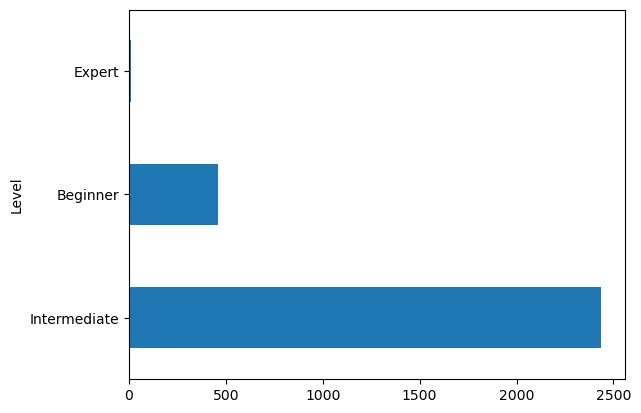

In [1705]:
# Sorted bv level
bigdf['Level'].value_counts().plot.barh()

<Axes: ylabel='Type'>

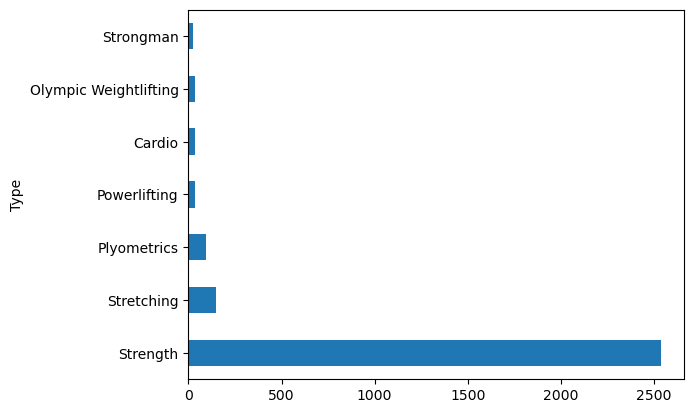

In [1706]:
# sorted by type
bigdf['Type'].value_counts().plot.barh()

<Axes: ylabel='BodyPart'>

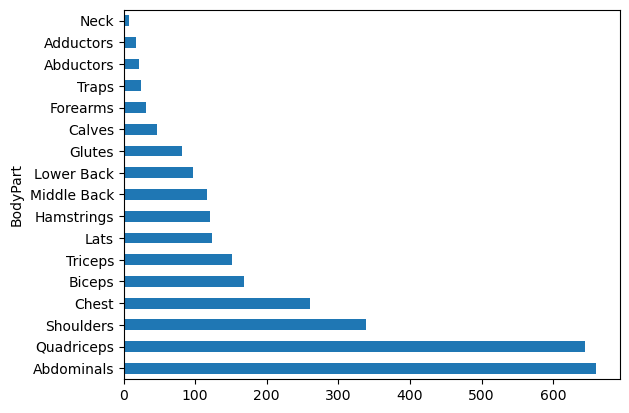

In [1707]:
# sorted by bodypart
bigdf['BodyPart'].value_counts().plot.barh()

In [1708]:
# top rated exercises
ratingSorted= bigdf.sort_values(by='Rating',ascending=False)
ratingSorted =ratingSorted.head(10)
ratingSorted

,index,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
1195,1195,Rickshaw Carry,NaN,Strongman,Forearms,Other,Beginner,9.6,Average
2065,2065,Single-Leg Press,The single-leg leg press is an exercise target...,Strength,Quadriceps,Machine,Intermediate,9.6,Average
1695,1695,T-Bar Row with Handle,NaN,Strength,Middle Back,Other,Intermediate,9.5,Average
731,731,Incline Hammer Curls,NaN,Strength,Biceps,Dumbbell,Beginner,9.5,Average
1179,1179,Palms-down wrist curl over bench,The palms-down wrist curl over bench is an exe...,Strength,Forearms,Barbell,Intermediate,9.5,Average
1577,1577,Atlas Stones,NaN,Strongman,Lower Back,Other,Intermediate,9.5,Average
1451,1451,Weighted pull-up,The weighted pull-up is a more advanced variat...,Strength,Lats,Other,Intermediate,9.5,Average
2525,2525,Dumbbell front raise to lateral raise,The dumbbell front raise to lateral raise is a...,Strength,Shoulders,Dumbbell,Intermediate,9.5,Average
1798,1798,Clean from Blocks,NaN,Olympic Weightlifting,Quadriceps,Barbell,Beginner,9.5,Average
88,88,Landmine twist,The landmine twist is a rotational abdominal m...,Strength,Abdominals,Other,Intermediate,9.5,Average


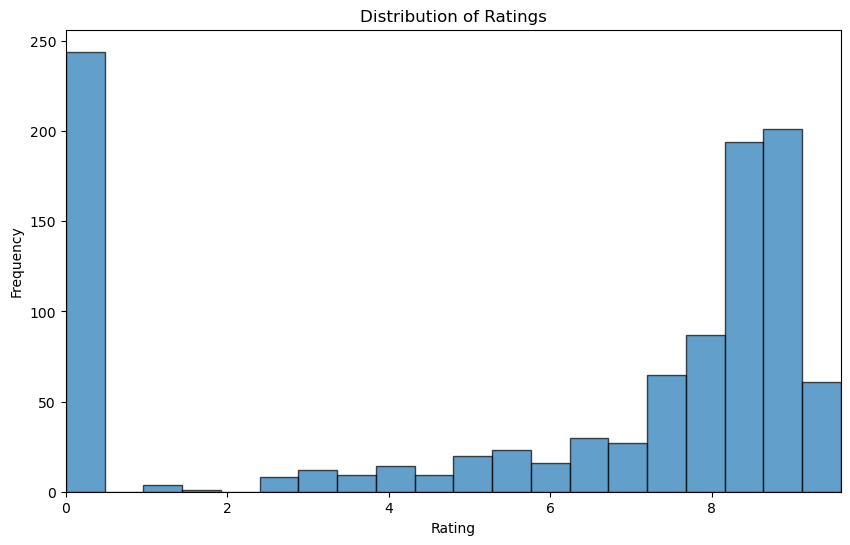

In [1709]:
# Distribution of ratings
df_sorted = bigdf.sort_values(by="Rating")
plt.figure(figsize=(10, 6))
plt.hist(df_sorted["Rating"], bins=20, edgecolor="k", alpha=0.7)

plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(False)
plt.xlim(df_sorted["Rating"].min(), df_sorted["Rating"].max())
plt.ylim(0, plt.gca().get_ylim()[1])
plt.show()

<h3>Using KNN to predict ratings for all exercises</h3>

In [1710]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from copy import deepcopy
import numpy as np

# Dataset for training. Converts all strings to categories (int) for KNN algorithm
x = deepcopy(bigdf)
x = x.drop(["Title"], axis = 1)
x = x.drop(["Desc"], axis = 1)
x = x.drop(["RatingDesc"], axis = 1)
x['Level'] = pd.factorize(x['Level'])[0]
x['Type'] = pd.factorize(x['Type'])[0]
x['BodyPart'] = pd.factorize(x['BodyPart'])[0]
x['Equipment'] = pd.factorize(x['Equipment'])[0]
x = x[x['Rating'].notna()]
x = x[x["Rating"] != 0]

# Values to be predicted
y = x["Rating"]
x = x.drop(["Rating"], axis = 1)

# Grid search to find the best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17],
    'p': [1, 2]
}
grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x, y)
params = grid_search.best_params_

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)


# Training
knn = KNeighborsRegressor(n_neighbors = params['n_neighbors'], p = params["p"])
knn.fit(x_train, y_train)

pred = knn.predict(x_test)

print("Evaluating the model:")
print(f"MAE: {mean_absolute_error(y_test, pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.2f}")

# New X, all exercises without ratings
x = deepcopy(bigdf)

# Excluding exercises with ratings
x = x[x['Rating'].isin([0, np.nan])]
x = x.drop(["Rating"], axis = 1)
x = x.drop(["Title"], axis = 1)
x = x.drop(["Desc"], axis = 1)
x = x.drop(["RatingDesc"], axis = 1)
x['Level'] = pd.factorize(x['Level'])[0]
x['Type'] = pd.factorize(x['Type'])[0]
x['BodyPart'] = pd.factorize(x['BodyPart'])[0]
x['Equipment'] = pd.factorize(x['Equipment'])[0]

# Amount of nonvalues
print("Nonvalues before:",bigdf["Rating"].isna().sum())

# All exercises without ratings are given a predicted rating
for index, row in x.iterrows():
    rating = knn.predict([row]).round(decimals=1)
    bigdf.loc[bigdf['index'] == index, 'Rating'] = rating

# Nonvalues after prediction
print("Nonvalues after",bigdf["Rating"].isna().sum())

filtered_df = bigdf[bigdf["Rating"] == 0]
print("Ratings with value zero:",len(filtered_df))

Evaluating the model:
MAE: 0.94
RMSE: 1.35
Nonvalues before: 1884
Nonvalues after 0
Ratings with value zero: 0


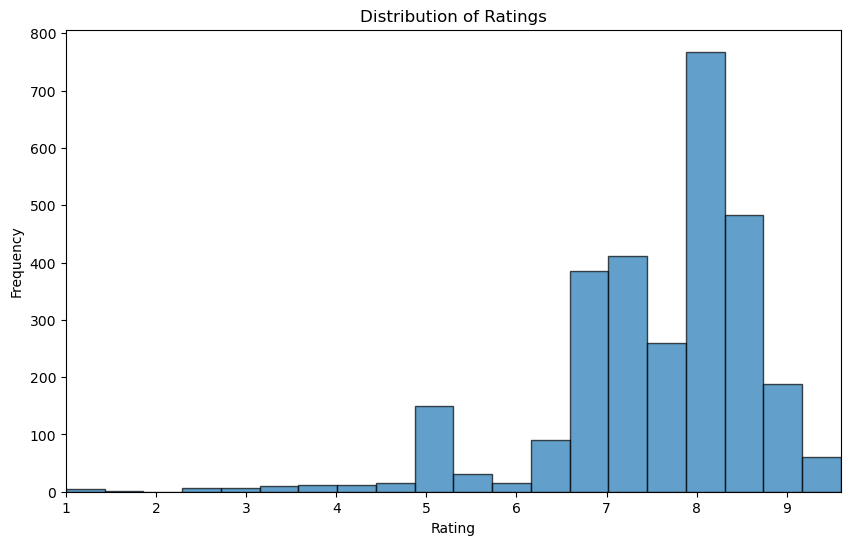

In [1711]:
# Ratings after KNN predicion
df_sorted = bigdf.sort_values(by="Rating")
plt.figure(figsize=(10, 6))
plt.hist(df_sorted["Rating"], bins=20, edgecolor="k", alpha=0.7)

plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(False)
plt.xlim(df_sorted["Rating"].min(), df_sorted["Rating"].max())
plt.ylim(0, plt.gca().get_ylim()[1])
plt.show()

In [1712]:
# Removing irrelevant columns
bigdf = bigdf.drop('RatingDesc', axis=1)
# Removing all rows containing nonvalues in description
bigdf = bigdf[bigdf['Desc'].notna()]
# Removing ID column
bigdf.pop(bigdf.columns[0])

0          0
1          1
2          2
3          3
4          4
        ... 
2911    2911
2912    2912
2913    2913
2915    2915
2916    2916
Name: index, Length: 1359, dtype: int64

In [1713]:
# Smaller dataframe consisting of 120 exercises
smalldf = pd.read_csv("100_exercises.csv", sep=";", names = ["index", "Title"])
bigdf['Title'] = bigdf['Title'].str.lower()
smalldf['Title'] = smalldf['Title'].str.lower()

# Adding columns from bigdf
smalldf = pd.merge(bigdf, smalldf, on="Title", how='inner')
smalldf['Title'] = smalldf['Title'].apply(lambda x: x.capitalize())
bigdf['Title'] = bigdf['Title'].apply(lambda x: x.capitalize())

clean_df = deepcopy(smalldf)

<h1>Cosine Similarity</h1>

In [1714]:
# Prints the row of the given Title to find the index
print(smalldf[smalldf["Title"] == "bench press"])

Empty DataFrame
Columns: [Title, Desc, Type, BodyPart, Equipment, Level, Rating, index]
Index: []


In [1715]:
# Merging columns for cosign similarity and dropping excess columns
smalldf["Merged"] = smalldf["Type"].astype(str) + '|' + \
  smalldf["BodyPart"].astype(str) + '|' + smalldf["Equipment"].astype(str) + '|' + \
  smalldf["Level"]

smalldf = smalldf.drop('Type', axis=1)
smalldf = smalldf.drop('BodyPart', axis=1)
smalldf = smalldf.drop('Equipment', axis=1)
smalldf = smalldf.drop('Level', axis=1)

# The merged columns
smalldf["Merged"]

0        Strength|Abdominals|Bands|Intermediate
1      Strength|Abdominals|Barbell|Intermediate
2        Strength|Abdominals|Other|Intermediate
3        Strength|Abdominals|Other|Intermediate
4        Strength|Abdominals|Cable|Intermediate
                         ...                   
109         Strength|Triceps|Cable|Intermediate
110         Strength|Triceps|Cable|Intermediate
111         Strength|Triceps|Cable|Intermediate
112         Strength|Triceps|Cable|Intermediate
113         Strength|Triceps|Cable|Intermediate
Name: Merged, Length: 114, dtype: object

In [1716]:
# Converting values of the merged column into vectors

from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
count_matrix = count.fit_transform(smalldf.loc[:,"Merged"])

liste = count_matrix.toarray()

In [1717]:
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(count_matrix, count_matrix)

In [1718]:
# Resetting the index to avoid indexing errors and NAN values in recommender
# This makes the previous indexes invalid
# "drop" avoids adding the old index as a column
smalldf = smalldf.reset_index(drop = False)

In [1719]:
def recommender(data_frame, exercise_id, sim_matrix):
    sim_df = pd.DataFrame(sim_matrix[exercise_id],
                         columns=["Similarity"])
    exercise_titles = data_frame.loc[:, "Title"]
    exercise_rec = pd.concat([sim_df, exercise_titles], axis = 1)
    exercise_rec = exercise_rec.sort_values(by="Similarity", ascending=False)
    
    return exercise_rec

In [1720]:
# Prints the row of the given Title to find the index
print(smalldf[smalldf["Title"] == "bench press"])

Empty DataFrame
Columns: [level_0, Title, Desc, Rating, index, Merged]
Index: []


In [1721]:
# Exercises similar to bench press
df_by_cat = recommender(smalldf, 26, sim_matrix)
df_by_cat

,Similarity,Title
26,1.000000,Bench press
25,1.000000,Incline bench press
23,1.000000,Decline barbell bench press
22,1.000000,Close-grip bench press
57,0.750000,Barbell deadlift
...,...,...
73,0.250000,Machine seated row
91,0.250000,Stair climber
94,0.223607,Burpee
65,0.223607,Reverse lunge


<h1>TDIDF</h1>

In [1722]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [1723]:
tfidf = TfidfVectorizer(stop_words="english")
overview_matrix = tfidf.fit_transform(smalldf["Desc"])
overview_matrix.shape

(114, 730)

In [1724]:
similarity_matrix = linear_kernel(overview_matrix, overview_matrix)
print(similarity_matrix[0:5,0:5])

[[1.         0.26344683 0.13452304 0.04243455 0.32930066]
 [0.26344683 1.         0.13986979 0.07243963 0.35565034]
 [0.13452304 0.13986979 1.         0.03534577 0.17908415]
 [0.04243455 0.07243963 0.03534577 1.         0.08616386]
 [0.32930066 0.35565034 0.17908415 0.08616386 1.        ]]


In [1725]:
mapping = pd.Series(smalldf.index, index = smalldf["Desc"])
mapping

Desc
The crunch is a popular core exercise targeting the rectus abdominis, or "six-pack" muscles, as well as the obliques. It has been the centerpiece of many ab-focused workouts, due to both its simplicity and the intense burn and mind-muscle connection it produces. It can be performed for time or reps as part of the ab-focused portion of any workout.                                                                                                                                                          0
The decline plate sit-up is a weighted core exercise that works the rectus abdominis or "six pack" muscles, as well as the deep core muscles. Weighted sit-up variations are usually performed for moderate to high reps, such as 8-12 reps per set or more, as part of the core-focused portion of a workout.                                                                                                                                                                                            

In [1726]:
def recommender_by_desc(exercise_input, df, similarity_matrix, mapping):
    exercise_index = mapping[exercise_input]
    if not isinstance(exercise_index, np.int64):
        exercise_index = exercise_index[0]
    similarity_score = list(enumerate(similarity_matrix[exercise_index]))
    score = [tup[1] for tup in similarity_score]
    exercise_indices = [i[0] for i in similarity_score]
    df2 = df["Title"].iloc[exercise_indices].to_frame()
    df2["Similarity"] = score
    return df2


In [1727]:
df_by_desc = recommender_by_desc(smalldf["Desc"][26], smalldf, similarity_matrix, mapping)
df_by_desc.sort_values(by="Similarity", ascending=False).iloc[:10]

,Title,Similarity
26,Bench press,1.000000
22,Close-grip bench press,0.436486
31,Smith machine bench press,0.318955
23,Decline barbell bench press,0.314967
33,Smith machine incline bench press,0.310092
25,Incline bench press,0.303273
20,Incline band bench press,0.288850
96,Military press,0.265964
78,Smith machine bent-over row,0.264233
87,Dumbbell lunges,0.227504


<h1>Combined Recommender (Cosine similarity + TDIDF)</h1>

In [1728]:
merged_df = df_by_cat.copy()
merged_df["Similarity"] = (df_by_cat["Similarity"] + df_by_desc["Similarity"]) / 2
merged_df = merged_df.sort_values(by=["Similarity"], ascending=False)
merged_df[0:10]

,Similarity,Title
26,1.000000,Bench press
22,0.718243,Close-grip bench press
23,0.657483,Decline barbell bench press
25,0.651637,Incline bench press
31,0.534478,Smith machine bench press
33,0.530046,Smith machine incline bench press
20,0.519425,Incline band bench press
96,0.507982,Military press
32,0.481912,Machine chest press
24,0.476599,Wide-grip bench press


<h1>Constraint Based Recommender</h1>

In [1729]:
# Dataframe without merged columns
df = deepcopy(bigdf)

def knowledge_based_rec(dataframe, type=None, bodypart=None, equipment=None, level=None):
    if type:
        dataframe = dataframe[dataframe["Type"] == type]
    if bodypart:
        dataframe = dataframe[dataframe["BodyPart"] == bodypart]
    if equipment:
        dataframe = dataframe[dataframe["Equipment"] == equipment]
    if level:
        dataframe = dataframe[dataframe["Level"] == level]

    recommendations = dataframe[["Title" , "Rating"]]
    return recommendations.sort_values(by="Rating", ascending=False).iloc[:10]

print(knowledge_based_rec(df, type="", bodypart="Chest", equipment="Barbell", level=""))

                                       Title  Rating
927                   Close-grip bench press     9.1
928        Barbell bench press - medium grip     9.0
929              Decline barbell bench press     8.9
930                    Wide-grip bench press     8.9
932  Barbell incline bench press medium-grip     8.8
945                           Up bench press     8.2
948   King maker incline barbell bench press     8.2
947           King maker barbell bench press     8.2
946                Up close-grip bench press     8.2
942                              Bench press     8.2


In [1730]:
# SMALL DATAFRAME
df = deepcopy(clean_df)
def knowledge_based_rec(dataframe, type=None, bodypart=None, equipment=None, level=None):
    if type:
        dataframe = dataframe[df["Type"] == type]
    if bodypart:
        dataframe = dataframe[df["BodyPart"] == bodypart]
    if equipment:
        dataframe = dataframe[df["Equipment"] == equipment]
    if level:
        dataframe = dataframe[df["Level"] == level]

    recommendations = dataframe[["Title" , "Rating"]]
    return recommendations.sort_values(by="Rating", ascending=False).iloc[:10]

print(knowledge_based_rec(df, type="", bodypart="Chest", equipment="Barbell", level=""))

                          Title  Rating
22       Close-grip bench press     9.1
23  Decline barbell bench press     8.9
24        Wide-grip bench press     8.9
26                  Bench press     8.2
25          Incline bench press     8.0


<h1>Knowledge Based GUI</h1>
<p> This is commented out so it doesn't stall the code. </p>

In [1731]:
""" import pandas as pd
import tkinter as tk
from tkinter import ttk

df = deepcopy(clean_df)

# Create a tkinter GUI
root = tk.Tk()
root.title("Gym Exercise Recommender")

# Function to filter and display exercises
def recommend_exercises():
    selected_bodypart = bodypart_var.get()
    selected_level = level_var.get()
    selected_type = type_var.get()

    filtered_df = df[
        (df['BodyPart'] == selected_bodypart) &
        (df['Level'] == selected_level) &
        (df['Type'] == selected_type)
    ]

    exercise_list.delete(0, tk.END)  # Clear the listbox

    for i, title in enumerate(filtered_df['Title']):
        exercise_list.insert(tk.END, f'{i + 1}. {title}')

# Create and configure GUI elements
bodypart_label = ttk.Label(root, text="Select Body Part:")
bodypart_label.pack()
my_bps = [i for i in df["BodyPart"].unique()]
bodypart_var = ttk.Combobox(root, values=my_bps)
bodypart_var.pack()

level_label = ttk.Label(root, text="Select Level:")
level_label.pack()
my_levels = [i for i in df["Level"].unique()]
level_var = ttk.Combobox(root, values=my_levels)
level_var.pack()

type_label = ttk.Label(root, text="Select Type:")
type_label.pack()
my_types = [i for i in df["Type"].unique()]
type_var = ttk.Combobox(root, values=my_types)
type_var.pack()

recommend_button = ttk.Button(root, text="Recommend Exercises", command=recommend_exercises)
recommend_button.pack()

exercise_list = tk.Listbox(root)
exercise_list.pack()

#root.mainloop() """

' import pandas as pd\nimport tkinter as tk\nfrom tkinter import ttk\n\ndf = deepcopy(clean_df)\n\n# Create a tkinter GUI\nroot = tk.Tk()\nroot.title("Gym Exercise Recommender")\n\n# Function to filter and display exercises\ndef recommend_exercises():\n    selected_bodypart = bodypart_var.get()\n    selected_level = level_var.get()\n    selected_type = type_var.get()\n\n    filtered_df = df[\n        (df[\'BodyPart\'] == selected_bodypart) &\n        (df[\'Level\'] == selected_level) &\n        (df[\'Type\'] == selected_type)\n    ]\n\n    exercise_list.delete(0, tk.END)  # Clear the listbox\n\n    for i, title in enumerate(filtered_df[\'Title\']):\n        exercise_list.insert(tk.END, f\'{i + 1}. {title}\')\n\n# Create and configure GUI elements\nbodypart_label = ttk.Label(root, text="Select Body Part:")\nbodypart_label.pack()\nmy_bps = [i for i in df["BodyPart"].unique()]\nbodypart_var = ttk.Combobox(root, values=my_bps)\nbodypart_var.pack()\n\nlevel_label = ttk.Label(root, text="Sel

<h1>Collaborative filtering</h1>

In [1732]:
# Collaborative filtering
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader

# Reading DataFrame
ratings_df = pd.read_csv("user_ratings.csv")

# Converting to the correct format
ratings = ratings_df.melt(id_vars=['Users'], var_name='Exercise', value_name='Rating')
print(ratings)
# Factorization?
ratings['Exercise'] = pd.factorize(ratings['Exercise'])[0]
# Use ratings DataFrame for pivoting
ratings = ratings.fillna(0).astype(int)
# Training
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(ratings[["Users", "Exercise", "Rating"]], reader)
trainset = data.build_full_trainset()

# Variables
user_rating = trainset.ur
item_rating = trainset.ir
num_users = trainset.n_users
num_items = trainset.n_items
num_ratings = trainset.n_ratings

print("Users", num_users)
print("Items", num_items)
print("Ratings", num_ratings)
density = num_ratings / (num_users * num_items) 
density = np.round(density, decimals=2)
sparsity = 1 - density
print("Density:", density*100, "%")
print("Sparsity:", sparsity*100, "%")


sim_options = {"name": "pearson",
               "user based": True,
               "shrinkage": 0}

rec = KNNBasic(sim_options=sim_options)
rec.fit(trainset)

user_sim_matrix = rec.sim

      Users              Exercise  Rating
0         1           Bench press     NaN
1         2           Bench press     NaN
2         3           Bench press     NaN
3         4           Bench press     NaN
4         5           Bench press    10.0
...     ...                   ...     ...
2635     18  cable rope push-down     8.0
2636     19  cable rope push-down     NaN
2637     20  cable rope push-down     NaN
2638     21  cable rope push-down     NaN
2639     22  cable rope push-down     NaN

[2640 rows x 3 columns]
Users 22
Items 120
Ratings 2640
Density: 100.0 %
Sparsity: 0.0 %
Computing the pearson similarity matrix...
Done computing similarity matrix.


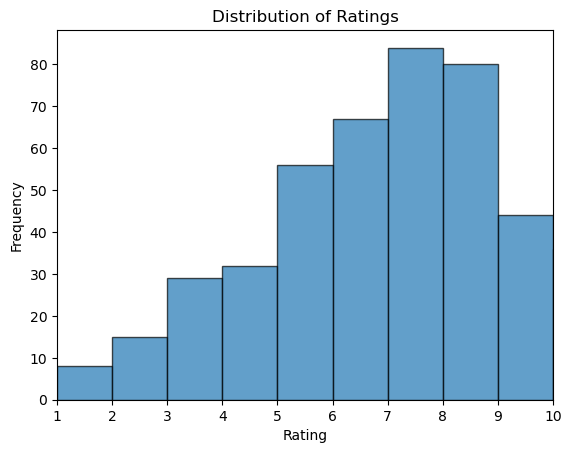

In [1746]:
df = pd.read_csv("user_ratings.csv")

ratings_columns = df.columns[1:]
ratings_data = df[ratings_columns].values.flatten()
plt.hist(ratings_data, bins=range(1, 12), edgecolor="k", alpha=0.7)

plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(False)
plt.xlim(1, 10)
plt.ylim(0, plt.gca().get_ylim()[1])
plt.show()


In [1734]:
def userbased_cf(user):
    # Readimg DataFrame
    ratings2 = pd.read_csv("user_ratings.csv")

    ratings2 = ratings2.drop(columns="Users")
    ratings2.index.name = "Users"
    ratings2.columns.name = "Exercises"
    ratings_norm = ratings2.copy()
    ratings_norm = ratings_norm.subtract(ratings2.mean(axis=1), axis = "rows")
    
    user_similarity = ratings_norm.T.corr()
    picked_user = user

    user_similarity.drop(index=picked_user, inplace=True)
    
    n = 10

    user_similarity_threshold = 0.2

    similar_users = user_similarity[user_similarity[picked_user]>user_similarity_threshold][picked_user].sort_values(ascending=False)[:n]
    picked_user_done = ratings_norm[ratings_norm.index == picked_user].dropna(axis=1, how="all")
    similar_user_exercises = ratings_norm[ratings_norm.index.isin(similar_users.index)].dropna(axis=1, how="all")
    similar_user_exercises.drop(picked_user_done.columns, axis=1, inplace=True, errors='ignore')

    # A dictionary of item scores
    item_score = {}

    for i in similar_user_exercises.columns:
        exercise_rating = similar_user_exercises[i]
        total = 0
        count = 0
        for u in similar_users.index:
            if pd.isna(exercise_rating[u]) == False:
                score = similar_users[u] * exercise_rating[u]
                total += score
                count +=1
        item_score[i] = total / count

    # Convert dictionary to pandas dataframe
    item_score = pd.DataFrame(item_score.items(), columns=['exercise', 'exercise_score'])
    
    # Sort the exercises by score
    ranked_item_score = item_score.sort_values(by="exercise_score", ascending=False)

    # Select top m exercises
    m = 10
    return(ranked_item_score.head(m))

In [1735]:
# USER BASED + EVALUATION

from sklearn.model_selection import train_test_split

X = ratings.copy()
y = ratings["Users"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)
 
r_matrix = X_train.pivot_table(values='Rating', index='Users', columns='Exercise')
r_matrix = r_matrix.fillna(0).astype(int)
print(r_matrix.head())

def cf_user_mean(user, exercise):
    if exercise in r_matrix:
        mean_rating = r_matrix[exercise].mean() 
    else:
        mean_rating = 5.0
    
    return mean_rating

from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def score(cf_model):
    id_pairs = zip(X_test['Users'], X_test['Exercise'])
    y_pred = np.array([cf_model(User, Exercise) for (User, Exercise) in id_pairs])
    y_true = np.array(X_test['Rating'])

    return rmse(y_true, y_pred)

def baseline(User, Exercise):
    return 5.0


print(score(baseline))
print(score(cf_user_mean))

Exercise  0    1    2    3    4    5    6    7    8    9    ...  110  111  \
Users                                                       ...             
1           0    0    0    0    0    8    0    0    0    0  ...    8    0   
2           0    0    0    0    0    0    0    7    0    0  ...    6    0   
3           0    0    0    0    0    0    0    6    0    6  ...    0    0   
4           0    0    0    7    0    0    0    0    0    0  ...    0    0   
5           0    0    0    0    0    6    0    0    0    0  ...    0    0   

Exercise  112  113  114  115  116  117  118  119  
Users                                             
1           0    0    0    0    0    0    0    0  
2           6    0    0    0    0    0    0    0  
3           0    8    0    0    0    0    0    0  
4           0    0    9    0    0    0    0    0  
5           0    0    0    0    0    0    0    0  

[5 rows x 120 columns]
4.690146559274534
2.6692666310446236


<h1>Evaluation</h1>

In [1736]:
# Our model changed to output a dataframe that can be used for evaluation
def userbased_cf_eval(user):
    # Reading DataFrame
    ratings2 = pd.read_csv("user_ratings.csv")
    ratings2 = ratings2.drop(columns="Users")
    ratings2.index.name = "Users"
    ratings2.columns.name = "Exercises"
    ratings_norm = ratings2.copy()
    ratings_norm = ratings_norm.subtract(ratings2.mean(axis=1), axis = "rows")
    
    user_similarity = ratings_norm.T.corr()
    picked_user = user

    user_similarity.drop(index=picked_user, inplace=True)
    
    n = 10

    user_similarity_threshold = 0.2

    similar_users = user_similarity[user_similarity[picked_user]>user_similarity_threshold][picked_user].sort_values(ascending=False)[:n]
    similar_user_exercises = ratings_norm[ratings_norm.index.isin(similar_users.index)].dropna(axis=1, how="all")

    item_score = {}

    for i in similar_user_exercises.columns:
        exercise_rating = similar_user_exercises[i]
        total = 0
        count = 0
        for u in similar_users.index:
            if pd.isna(exercise_rating[u]) == False:
                score = similar_users[u] * exercise_rating[u]
                total += score
                count +=1
        item_score[i] = total / count

    item_score = pd.DataFrame(item_score.items(), columns=['exercise', 'exercise_score'])
    avg_rating = ratings2[ratings2.index == picked_user].T.mean(skipna=True)[picked_user]
    print(f'The average exercise rating for user {picked_user+1} is {avg_rating:.2f}')

    predicted_ratings = pd.DataFrame({
        'Users': picked_user+1,
        'Exercise': item_score['exercise'],
        'Predicted_Ratings': np.clip((item_score['exercise_score'] + avg_rating).round().astype(int), 1, 10)
    }).reset_index(drop=True)

    return predicted_ratings


In [1737]:
results_list = []

# Iterate through each user
for user_id in range(num_users):
    user_results = userbased_cf_eval(user_id)
    user_results['user_id'] = user_id
    results_list.append(user_results)

results_df = pd.concat(results_list, ignore_index=True)

results_df = results_df.drop(['user_id'], axis=1)

The average exercise rating for user 1 is 6.91
The average exercise rating for user 2 is 6.24
The average exercise rating for user 3 is 6.08
The average exercise rating for user 4 is 6.10
The average exercise rating for user 5 is 7.22
The average exercise rating for user 6 is 4.83
The average exercise rating for user 7 is 5.53
The average exercise rating for user 8 is 7.06
The average exercise rating for user 9 is 6.09
The average exercise rating for user 10 is 6.95
The average exercise rating for user 11 is 7.55
The average exercise rating for user 12 is 5.48
The average exercise rating for user 13 is 6.44
The average exercise rating for user 14 is 5.38
The average exercise rating for user 15 is 7.09
The average exercise rating for user 16 is 5.70
The average exercise rating for user 17 is 7.13
The average exercise rating for user 18 is 6.72
The average exercise rating for user 19 is 6.46
The average exercise rating for user 20 is 7.43
The average exercise rating for user 21 is 6.90
T

In [1738]:

# Calculating RMSE
ratings_df = pd.read_csv("user_ratings.csv")

# Converting to the correct format
ratings_melted = ratings_df.melt(id_vars=['Users'], var_name='Exercise', value_name='Rating')
merged_df = pd.merge(ratings_melted, results_df, on=['Users', 'Exercise'], how='left')
merged_df = merged_df.dropna(subset=['Rating', 'Predicted_Ratings'])
merged_df = merged_df.sort_values(by='Users')
merged_df['squared_diff'] = (merged_df['Predicted_Ratings'] - merged_df['Rating'])**2
# Mean absolute error
our_mse = merged_df['squared_diff'].mean()

# Root Mean Squared Error (RMSE)
our_rmse = np.sqrt(our_mse)

print(f'RMSE: {our_rmse:.4f}')
print(f'MSE: {our_mse:.4f}')

RMSE: 1.6835
MSE: 2.8343


In [1739]:

merged_df['Absolute_Difference'] = np.abs(merged_df['Rating'] - merged_df['Predicted_Ratings'])

# Mean Absolute Error (MAE)
our_mae = merged_df['Absolute_Difference'].mean()

print(f'Mean Absolute Error (MAE): {our_mae}')

Mean Absolute Error (MAE): 1.2837078651685394


In [1740]:
# Rank the predicted ratings for each user
merged_df['Rank'] = merged_df.groupby('Users')['Predicted_Ratings'].rank(ascending=False)

concordant_pairs = merged_df[merged_df['Rating'] > merged_df['Predicted_Ratings']].shape[0]
discordant_pairs = merged_df[merged_df['Rating'] < merged_df['Predicted_Ratings']].shape[0]

our_fcp = concordant_pairs / (concordant_pairs + discordant_pairs)

print(f'Fraction of Concordant Pairs (FCP): {our_fcp}')

Fraction of Concordant Pairs (FCP): 0.5318352059925093


In [1741]:
# Precision and recall
threshold = 7

merged_df['True_Positive'] = merged_df['Rating'] >= threshold
merged_df['Predicted_Positive'] = merged_df['Predicted_Ratings'] >= threshold

true_positives = merged_df[(merged_df['True_Positive']) & (merged_df['Predicted_Positive'])].shape[0]
false_positives = merged_df[(~merged_df['True_Positive']) & (merged_df['Predicted_Positive'])].shape[0]
false_negatives = merged_df[(merged_df['True_Positive']) & (~merged_df['Predicted_Positive'])].shape[0]

our_precision = true_positives / (true_positives + false_positives)
our_recall = true_positives / (true_positives + false_negatives)

print(f'Precision: {our_precision:.3f}')
print(f'Recall: {our_recall:.3f}')

Precision: 0.780
Recall: 0.768


In [1742]:
#Evaluation of other models

from eval_metrics import precision_recall_at_k
from surprise import SVD
from surprise import SVDpp
from surprise import KNNBaseline
from surprise import BaselineOnly
from surprise import NormalPredictor
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from tabulate import tabulate

ratings_df = pd.read_csv("user_ratings.csv")

ratings = ratings_df.melt(id_vars=['Users'], var_name='Exercise', value_name='Rating')
ratings['Exercise'] = pd.factorize(ratings['Exercise'])[0]
ratings = ratings.fillna(0).astype(int)


reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings.iloc[:,0:3], reader)

trainset, testset = train_test_split(data, test_size=0.3)

table = []
rec_n = 0

recommenders = (SVD, SVDpp, KNNBasic, KNNBaseline, BaselineOnly, NormalPredictor)
titles = ("SVD", "SVD++", "KNN-Basic", "KNN-Baseline", "Baseline", "Random")

for rec in recommenders:
    rec_alg = rec()
    rec_alg.fit(trainset)
    predictions = rec_alg.test(testset)

    p, r = precision_recall_at_k(predictions, k=7, threshold=2)
    precision = "{:.3f}".format(p)
    recall = "{:.3f}".format(r)

    new_line = [titles[rec_n], precision, recall]
    table.append(new_line)
    rec_n += 1

header = ["recommenders", "precision", "recall"]
table.insert(0, ["User Based CF",  "{:.3f}".format(our_precision),  "{:.3f}".format(our_recall)])
print(tabulate(table, header, tablefmt="pipe"))

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
| recommenders   |   precision |   recall |
|:---------------|------------:|---------:|
| User Based CF  |       0.78  |    0.768 |
| SVD            |       0.216 |    0.139 |
| SVD++          |       0.174 |    0.154 |
| KNN-Basic      |       0.163 |    0.114 |
| KNN-Baseline   |       0.181 |    0.127 |
| Baseline       |       0.091 |    0.019 |
| Random         |       0.188 |    0.231 |


In [1743]:
ratings_df = pd.read_csv("user_ratings.csv")

ratings = ratings_df.melt(id_vars=['Users'], var_name='Exercise', value_name='Rating')

ratings['Exercise'] = pd.factorize(ratings['Exercise'])[0]
ratings = ratings.fillna(0).astype(int)

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings.iloc[:,0:3], reader)

kf = KFold(random_state=0)

table = []
titles = titles = ("SVD", "SVD++", "KNN-Basic", "KNN-Baseline", "Baseline", "Random")
fold_n = 0
for rec in recommenders:
    out = cross_validate(rec(), data, ["rmse", "mae", "fcp",], kf)
    mean_rmse = "{:.3f}".format(np.mean(out["test_rmse"]))
    mean_mae = "{:.3f}".format(np.mean(out["test_mae"]))
    mean_fcp = "{:.3f}".format(np.mean(out["test_fcp"]))
    fit_time = "{:.3f}".format(np.mean(out["fit_time"]))

    new_line = [titles[fold_n], mean_rmse, mean_mae, mean_fcp, fit_time]
    table.append(new_line)
    fold_n += 1
table.insert(0, ["User Based CF",  "{:.3f}".format(our_rmse),  "{:.3f}".format(our_mae), "{:.3f}".format(our_fcp), '0'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases usin

In [1744]:
header = ["Recommenders", "Pred Accuracy [RMSE]", "Pred Accuracy [MAE]", "Pred Accuracy [FCP]", "Training Time [sec]"]
print(tabulate(table, header, tablefmt="pipe"))

| Recommenders   |   Pred Accuracy [RMSE] |   Pred Accuracy [MAE] |   Pred Accuracy [FCP] |   Training Time [sec] |
|:---------------|-----------------------:|----------------------:|----------------------:|----------------------:|
| User Based CF  |                  1.684 |                 1.284 |                 0.532 |                 0     |
| SVD            |                  2.634 |                 1.997 |                 0.444 |                 0.009 |
| SVD++          |                  2.754 |                 2.114 |                 0.435 |                 0.092 |
| KNN-Basic      |                  2.622 |                 1.957 |                 0.442 |                 0     |
| KNN-Baseline   |                  2.632 |                 1.979 |                 0.431 |                 0.001 |
| Baseline       |                  2.614 |                 1.923 |                 0.414 |                 0.001 |
| Random         |                  3.218 |                 2.557 |     